In [1]:
def restore_all(data_save_dir):
    global agent, all_reward, all_episode
    # restore the parameters of networks, i.e., Weight and Bias.
    tf.train.Saver().restore(agent.session,tf.train.latest_checkpoint("model/"))
    # restore replay memory
    agent.replay_buffer = deque( np.load(data_save_dir+"/replay_buffer.npy", allow_pickle=True) )
    # restore reward list
    all_reward = np.load(data_save_dir+"/all_reward.npy").tolist()
    # restore episode count
    all_episode = np.load(data_save_dir+"/all_episode.npy")[0]

In [2]:
def save_all(data_save_dir):
    global agent, all_reward, all_episode
    # save the parameters of networks, i.e., Weight and Bias.
    tf.train.Saver().save(agent.session, "model/model", global_step=all_episode)
    # save replay memory
    np.save(data_save_dir+"/replay_buffer", agent.replay_buffer)
    # save reward list
    np.save(data_save_dir+"/all_reward", all_reward)
    # save episode count
    np.save(data_save_dir+"/all_episode", [all_episode])

In [3]:
CONFIG = {
    "dense": 1,
}

In [4]:
import numpy as np
from scipy.linalg import expm
import random

class move_gym():
    def __init__(self):
        self.scope = 2.0
        self.states = 6
        self.actions = 4
    def reset(self):

        self.obstacle_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.obstacle_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1

        self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1  
        while ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 ):
            self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1      

        self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        while (  ( abs(self.obstacle_x-self.target_x) < 1.05 ) & ( abs(self.obstacle_y-self.target_y) < 1.05 )  ) |\
         (  ( abs(self.move_x-self.target_x) < 1.05 ) & ( abs(self.move_y-self.target_y) < 1.05 )  ):
            self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1        

        state=np.array( [ self.move_x, self.move_y, self.obstacle_x, self.obstacle_y, self.target_x, self.target_y ])
        
        return state #, self.state2img(state)
    def step(self, action):
        velocity = 0.2
        if action==0: # up down right left
            self.move_y+=velocity
        if action==1:
            self.move_y-=velocity
        if action==2:
            self.move_x+=velocity
        if action==3:
            self.move_x-=velocity

        if self.move_x > (self.scope+1.0):
            self.move_x-=velocity
        if self.move_x < (-self.scope-1.0):
            self.move_x+=velocity
        if self.move_y > (self.scope+1.0):
            self.move_y-=velocity
        if self.move_y < (-self.scope-1.0):
            self.move_y+=velocity
        
        reward = -0.1
        done = False
        info = "^_^"
        if (  ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 )  ): 
            reward = -1.0 
            done = True
            info = "collision"

        elif (  ( abs(self.target_x-self.move_x) < 1.05 ) & ( abs(self.target_y-self.move_y) < 1.05 )  ):
            reward = 1.0
            done = True
            info = "reach"
            
        state=np.array( [ self.move_x, self.move_y, self.obstacle_x, self.obstacle_y, self.target_x, self.target_y ])

        return state, reward,done,info
    def state2img(self, state):
        img = np.zeros([84,84,3], dtype=np.uint8)
        ( img[ int(42-(self.obstacle_y+0.5)*10):int(42-(self.obstacle_y-0.5)*10), int((self.obstacle_x-0.5)*10+42):int((self.obstacle_x+0.5)*10+42),2 ] ).fill(255)
        ( img[ int(42-(self.target_y+0.5)*10):int(42-(self.target_y-0.5)*10), int((self.target_x-0.5)*10+42):int((self.target_x+0.5)*10+42),1 ] ).fill(255)
        ( img[ int(42-(self.move_y+0.5)*10):int(42-(self.move_y-0.5)*10), int((self.move_x-0.5)*10+42):int((self.move_x+0.5)*10+42),0 ] ).fill(255)
        return img

In [5]:
import tensorflow as tf
import numpy as np
from numpy import *
import random
from collections import deque

from tqdm import trange

# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
    # DQN Agent
    def __init__(self, env):
        # init experience replay
        self.replay_buffer = deque()
        # init. some parameters
        self.epsilon = INITIAL_EPSILON
        # self.state_dim = env.observation_space.shape[0]
        self.state_dim = env.states

        # self.action_dim = env.action_space.n
        self.action_dim = env.actions

        self.create_Q_network()
        self.create_training_method()

        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())

    def create_Q_network(self):
        print( "create new network weights ...")
        num_hid = 200
        
        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        
        if not CONFIG["dense"]:
            self.W1 = self.weight_variable([self.state_dim,num_hid])
            self.b1 = self.bias_variable([num_hid])
            self.W2 = self.weight_variable([num_hid,num_hid])
            self.b2 = self.bias_variable([num_hid])
            self.W3 = self.weight_variable([num_hid,self.action_dim])
            self.b3= self.bias_variable([self.action_dim])

            # hidden layers
            h_layer = tf.nn.relu(tf.matmul(self.state_input,self.W1) + self.b1)
            h_layer02 = tf.nn.relu(tf.matmul(h_layer,self.W2) + self.b2)
            
            # Q Value layer
            self.Q_value = tf.matmul(h_layer02,self.W3) + self.b3

        else:
            h_layer = tf.layers.dense( self.state_input, num_hid, activation=tf.nn.relu )
            h_layer2 = tf.layers.dense( h_layer, num_hid, activation=tf.nn.relu )
            self.Q_value = tf.layers.dense( h_layer2, self.action_dim )

    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def train_Q_network(self):
        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        # Step 2: calculate y
        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i])
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={
          self.y_input:y_batch,
          self.action_input:action_batch,
          self.state_input:state_batch
          })

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0]
        if random.random() < 0.5:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)

    def obtain_wb(self):
        W1=self.session.run(self.W1)
        b1=self.session.run(self.b1)
        W2=self.session.run(self.W2)
        b2=self.session.run(self.b2)
        W3=self.session.run(self.W3)
        b3=self.session.run(self.b3)
        return W1, b1, W2, b2, W3, b3

    def restore_wb(self):
        W1 = np.load( "W1.npy" )
        W2 = np.load( "W2.npy" )
        W3 = np.load( "W3.npy" )

        b1 = np.load( "b1.npy" )
        b2 = np.load( "b2.npy" )
        b3 = np.load( "b3.npy" )        
        return tf.Variable(W1), tf.Variable(b1), tf.Variable(W2), tf.Variable(b2), tf.Variable(W3), tf.Variable(b3)
    def use_nn(self,state):
        return self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })

    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0])

    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)
    
    
# Hyper Parameters
STEP = 50 # Step limitation in an episode
TEST = 10 # The number of experiment for test

# initialize env and agent
env = move_gym()
agent = DQN(env)

all_episode = 0
all_reward = []

W0104 19:44:20.446081 140291627591488 deprecation.py:323] From <ipython-input-5-5ec0d0c94174>:59: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0104 19:44:20.450358 140291627591488 deprecation.py:506] From /home/inksci/miniconda3/envs/py3-tfv4-sp1.2.1/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


create new network weights ...


In [5]:
restore_all("data-save")

W1217 22:05:58.167808 139787083765568 deprecation.py:323] From /home/inksci/miniconda3/envs/py3-tfv4-sp1.2.1/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [6]:
EPISODE = 1000
all_episode += EPISODE
for episode in trange(EPISODE):

    # Train
    state = env.reset()
    for step in range(STEP):
        action = agent.egreedy_action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        agent.perceive(state,action,reward,next_state,done)
        state = next_state
        if done:
            break

    # Test
    if (episode % 100) == 0:
        total_reward = 0
        for i in range(TEST):
            state = env.reset()
            for j in range(STEP):
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        
        all_reward.append( ave_reward )
        if (episode % (EPISODE//100)) == 0:
            print( 'episode: ',episode,'Evaluation Average Reward:',ave_reward)

  0%|          | 4/1000 [00:00<01:27, 11.35it/s]

episode:  0 Evaluation Average Reward: -3.6700000000000244


 10%|█         | 105/1000 [00:05<00:41, 21.75it/s]

episode:  100 Evaluation Average Reward: -1.92


 20%|██        | 204/1000 [00:09<00:36, 21.99it/s]

episode:  200 Evaluation Average Reward: -0.7399999999999988


 30%|███       | 304/1000 [00:12<00:22, 31.23it/s]

episode:  300 Evaluation Average Reward: -0.2999999999999998


 41%|████      | 407/1000 [00:15<00:20, 28.68it/s]

episode:  400 Evaluation Average Reward: -0.6099999999999988


 50%|█████     | 503/1000 [00:18<00:19, 25.79it/s]

episode:  500 Evaluation Average Reward: 0.039999999999999994


 60%|██████    | 604/1000 [00:21<00:14, 27.77it/s]

episode:  600 Evaluation Average Reward: -0.4399999999999988


 70%|███████   | 705/1000 [00:24<00:09, 29.97it/s]

episode:  700 Evaluation Average Reward: -0.5899999999999984


 81%|████████  | 807/1000 [00:28<00:05, 32.87it/s]

episode:  800 Evaluation Average Reward: -0.6299999999999977


 91%|█████████ | 906/1000 [00:30<00:02, 36.86it/s]

episode:  900 Evaluation Average Reward: -0.1400000000000005


100%|██████████| 1000/1000 [00:33<00:00, 29.45it/s]


In [7]:
print( all_episode, len(all_reward))

1000 10


In [7]:
save_all("data-save")

In [8]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

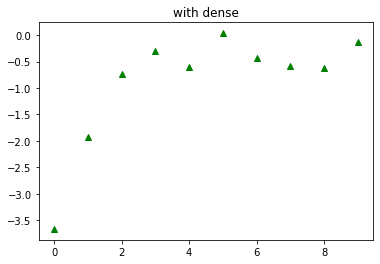

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
# ax.set_xlim(0.5, 4.5)
plt.title("with dense")
plt.show()

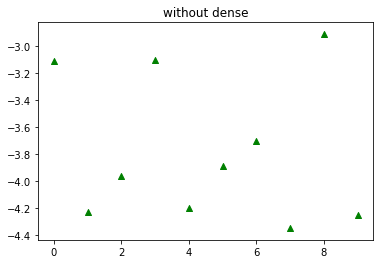

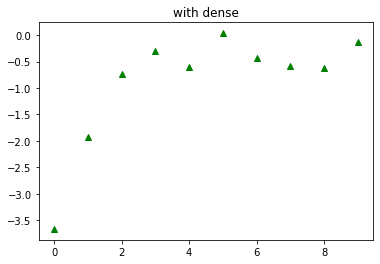


In [11]:
mean_reward=[]
for i in range( len(all_reward)-100 ):
    mean_reward.append( mean(all_reward[i:i+100]) )

In [12]:
max_reward=[]
for i in range( len(all_reward)-100 ):
    max_reward.append( max(all_reward[i:i+100]) )

In [13]:
min_reward=[]
for i in range( len(all_reward)-100 ):
    min_reward.append( min(all_reward[i:i+100]) )

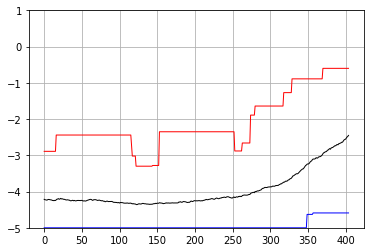

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(mean_reward)), mean_reward, color='black', linewidth=1) # plot line
ax.plot(range(len(max_reward)), max_reward, color='red', linewidth=1) # plot line
ax.plot(range(len(min_reward)), min_reward, color='blue', linewidth=1) # plot line
ax.set_ylim(-5, 1)
# ax.set_xlim(0, 3500)
plt.grid(True)
plt.show()

> Check

In [53]:
reach = 0
collision = 0
for i in trange(3000):

    state = env.reset()
    for j in xrange(STEP):
        action = agent.action(state) # direct action for test
        state,reward,done,info = env.step(action)
        total_reward += reward
        if done:
#             print info

            if info == "reach":
                reach += 1
            if info == "collision":
                collision += 1

            break
print "reach: ", reach, "collision: ", collision

100%|██████████| 3000/3000 [00:11<00:00, 252.29it/s]

reach:  2942 collision:  15


- The result of checking is not bad
- even we might improve the network with oversampling
- now we focus the design of logic controller

In [28]:
W1, b1, W2, b2, W3, b3 = agent.obtain_wb()

In [29]:
np.save('W1', W1)
np.save('W2', W2)
np.save('W3', W3)

np.save('b1', b1)
np.save('b2', b2)
np.save('b3', b3)